# Hebb則と教師なし学習 (1) 主成分分析
## Hebb則

Hebb_1949_The_Organization_of_Behavior

```{note}
日本語訳されている：行動の機構――脳メカニズムから心理学へ
```

> Let us assume then that the persistence or repetition of a reverberatory activity (or "trace") tends to induce lasting cellular changes that add to its stability The assumption' can be precisely stated as follows When an axon of cell A is near enough to excite a cell B and repeatedly or persistently takes part in firing It, some growth process or metabolic change takes place sn one or both cells such that A's efficiency, as one of the cats firing B, is increased

Hebb則はShatzにより"cells that fire together wire together" (共に活動する細胞は共に結合する)と韻を踏みながら短く言い換えられている．

> Shatz, C. J. 1992. “The Developing Brain.” Scientific American 267 (3): 60–67.

数式でHebb則を表してみよう．シナプス前活動を$\mathbf{x}\in \mathbb{R}^n$, 後活動を$\mathbf{y}\in \mathbb{R}^m$, 重み行列を$\mathbf{W}\in \mathbb{R}^{m\times n}$とし，$\mathbf{y}=\mathbf{W}\mathbf{x}$が成り立つとする．このようなモデルを線形ニューロンモデル (Linear neuron model)という．このとき，Hebb則は

$$
\frac{d\mathbf{W}}{dt}=\mathbf{y}\mathbf{x}^\top=(\text{post})\cdot (\text{pre})^\top
$$

として表される．

このHebb則は数学的に導出されたものではないが，特定の目的関数を神経活動及び重みを変化させて最適化するようなネットワークを構築すれば自然に出現する (本書ではこれに該当するIsingモデル，Amari-Hopfieldモデル，Boltzmannマシン，スパース符号化モデル，予測符号化モデルを取り上げる．もちろんこれ以外のモデルでも現れる)．こうしたモデルでは，先に目的関数$\mathcal{L}$を定義し，その目的関数を最小化するような神経活動$\mathbf{z}$および重み行列$\mathbf{W}$のダイナミクスをそれぞれ,

$$
\frac{d \mathbf{z}}{dt}\propto-\frac{\partial \mathcal{L}}{\partial \mathbf{z}},\ \frac{d \mathbf{W}}{dt}\propto-\frac{\partial \mathcal{L}}{\partial \mathbf{W}}
$$

として導出する．また，先に神経細胞の活動ダイナミクスを定義し，積分することで目的関数$\mathcal{L}$を導出できる(Isomura et al., 2022)．この場合，$\mathcal{L}$を重み行列で微分することでHebb則が導出できる．次のような連続時間線形ニューロンモデルを考えよう (記号は先ほどと同様である)．

$$
\frac{d\mathbf{y}}{dt}=\mathbf{W}\mathbf{x}
$$

ここで$\dfrac{\partial\mathcal{L}}{\partial\mathbf{y}}:=-\dfrac{d\mathbf{y}}{dt}$となるような目的関数 $\mathcal{L}\in \mathbb{R}$を仮定すると，

$$
\mathcal{L}=-\int \mathbf{W}\mathbf{x}\ d\mathbf{y}=-\mathbf{y}^\top \mathbf{W}\mathbf{x}
$$

となる．これをさらに$\mathbf{W}$で微分すると，

$$
\dfrac{\partial\mathcal{L}}{\partial\mathbf{W}}=-\mathbf{y}\mathbf{x}^\top\Rightarrow
\frac{d\mathbf{W}}{dt}=-\dfrac{\partial\mathcal{L}}{\partial\mathbf{W}}=\mathbf{y}\mathbf{x}^\top
$$

となり，Hebb則が導出できる．

また実験的にはLTPとして Bliss and Lømo (1973)により発見されている．

## 主成分分析 (Principal component analysis; PCA)

主成分分析の解説書く．SVDでの実装．

In [1]:
using PyPlot, Random, Distributions, LinearAlgebra, FFTW
rc("axes.spines", top=false, right=false)

In [2]:
function HebbianPCA(X; n_components=10, η=1e-6, maxiter=200, func=identity, orthogonal=true)
    # X : n x m -> Y : n_components x m
    n = size(X)[1]
    X = (X .- mean(X, dims=2)) ./ std(X, dims=2) # normalization
    Y = nothing
    W = randn(n_components, n) # initialize weight
    W ./= sqrt.(sum(W.^2, dims=2)) # normalization
    for _ in 1:maxiter
        Y = func.(W * X)
        if orthogonal
            W .+= η * (Y * X' - LowerTriangular(Y * Y') * W) # Sanger's rule
        else
            W .+= η * (Y * X' - Diagonal(Y * Y') * W) # Oja's rule
        end
    end
    return Y, W
end;

In [3]:
using MAT

In [14]:
# datasets from http://www.rctn.org/bruno/sparsenet/
mat_images_raw = matopen("../contents/_static/datasets/IMAGES_RAW.mat")
imgs = read(mat_images_raw, "IMAGESr")
#mat_images = matopen("../contents/_static/datasets/IMAGES.mat")
#imgs = read(mat_images, "IMAGES")

#close(mat_images)
close(mat_images_raw)

In [21]:
batch_size = 5000

5000

In [22]:
sz = 16

16

In [23]:
H, W, num_images = size(imgs)

(512, 512, 10)

In [24]:
num_inputs = sz^2

256

In [25]:
# Get the coordinates of the upper left corner of clopping image randomly.
beginx = rand(1:W-sz, batch_size)
beginy = rand(1:H-sz, batch_size)

inputs = zeros(batch_size, num_inputs)  # Input image patches

# Get images randomly
for i in 1:batch_size        
    idx = rand(1:num_images)
    img = imgs[:, :, idx]
    clop = img[beginy[i]:beginy[i]+sz-1, beginx[i]:beginx[i]+sz-1][:]
    inputs[i, :] = clop .- mean(clop)
end

In [26]:
@time Ypi, Wpi = HebbianPCA(inputs', n_components=25, η=1e-6, maxiter=2000, orthogonal=true)#, func=relu);

  8.924531 seconds (42.04 k allocations: 4.127 GiB, 2.55% gc time)


In [27]:
size(Wpi)

(25, 256)

In [28]:
W_pca = reshape(Wpi, (25, sz, sz));

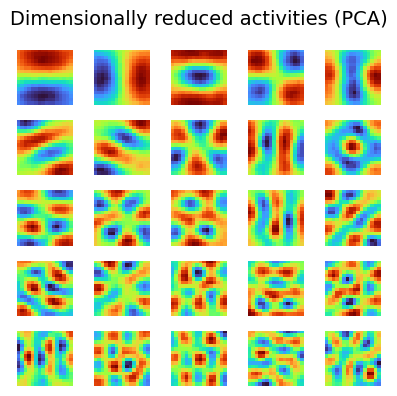

In [29]:
figure(figsize=(4,4))
suptitle("Dimensionally reduced activities (PCA)", fontsize=14)
for i in 1:25
    subplot(5,5,i)
    imshow(W_pca[i, :, :], cmap="turbo")
    axis("off")
end
tight_layout()

## 参考文献
```{bibliography}
:filter: docname in docnames
```